# CENG 483 THE 2

**Name:** Emirhan Yılmaz Güney

**Student ID:** 2443208

NOTE: Top-10 corners are marked 'blue'.

In [282]:
# Import libraries
import numpy as np
import cv2
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time
from numpy import linalg as LA
# You can use this code block (or add new code blocks here) to implement shared functionality.

img1 = cv2.cvtColor(cv2.imread("images/chessboard.png"),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("images/lab.png"),cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread("images/tree.png"),cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread("images/chessboard-rotated.png"),cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(cv2.imread("images/lab-rotated.png"),cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(cv2.imread("images/tree-rotated.png"),cv2.COLOR_BGR2RGB)

# Assuming you have a list of 6 images and their corners
images = [img1, img2, img3, img4, img5, img6]  # Replace img1, img2, etc., with your actual images
grayscales = [cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) for img in images]

def calculate_gradients(gray):
    # Calculate gradients using Sobel kernels
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    return Ix,Iy

def NMS_eliminator(non_maxima_indices,min_value_array,nms_radius):

    processed_corners = np.zeros_like(min_value_array)

    for i in range(0,non_maxima_indices.shape[0]):

        x,y=non_maxima_indices[i][0],non_maxima_indices[i][1]


        
        start_x, end_x = x - (nms_radius - 1) // 2, x + (nms_radius + 1) // 2
        start_y, end_y = y - (nms_radius - 1) // 2, y + (nms_radius + 1) // 2

        if start_x>(nms_radius+1)//2 and start_y>(nms_radius+1)//2 and end_x<min_value_array.shape[0]-((nms_radius+1)//2) and end_y<min_value_array.shape[0]-((nms_radius+1)//2):

            # Extract the neighborhood using slicing
        
            neighborhood = min_value_array[start_x:end_x, start_y:end_y]
            max_value = np.max(neighborhood)

            processed_neighborhood = np.zeros_like(neighborhood)
            processed_neighborhood[neighborhood == max_value] = 1

            processed_corners[start_x:end_x,start_y:end_y] = processed_neighborhood

    return processed_corners 

def nms_fast_implementation(harris_response, neighborhood_size=3, threshold=0.01):
    # Find corners with Harris response above the threshold

    processed_corners = np.zeros_like(harris_response)

    corners = (harris_response > threshold * harris_response.max()) 

    non_maxima_indices = np.column_stack(np.where(corners == 1))

    for i in range(0,non_maxima_indices.shape[0]):

        x,y=non_maxima_indices[i][0],non_maxima_indices[i][1]
        
        start_x, end_x = x - (neighborhood_size - 1) // 2, x + (neighborhood_size + 1) // 2
        start_y, end_y = y - (neighborhood_size - 1) // 2, y + (neighborhood_size + 1) // 2

        # Extract the neighborhood using slicing

        if start_x>(neighborhood_size+1)//2 and start_y>(neighborhood_size+1)//2 and end_x<harris_response.shape[0]-((neighborhood_size+1)//2) and end_y<harris_response.shape[0]-((neighborhood_size+1)//2):
    
            neighborhood = harris_response[start_x:end_x, start_y:end_y]
            max_value = np.max(neighborhood)

            processed_neighborhood = np.zeros_like(neighborhood)
            processed_neighborhood[neighborhood == max_value] = 1

            processed_corners[start_x:end_x,start_y:end_y] = processed_neighborhood

    return processed_corners


def nms_rgb_implementation(harris_response, neighborhood_size=3, threshold=0.01):
    # Find corners with Harris response above the threshold

    processed_corners = np.zeros((harris_response.shape[0],harris_response.shape[1]))

    corners = (harris_response > threshold * harris_response.max()) 

    non_maxima_indices = np.column_stack(np.where(corners == 1))

    for i in range(0,non_maxima_indices.shape[0]):

        x,y=non_maxima_indices[i][0],non_maxima_indices[i][1]
        
        start_x, end_x = x - (neighborhood_size - 1) // 2, x + (neighborhood_size + 1) // 2
        start_y, end_y = y - (neighborhood_size - 1) // 2, y + (neighborhood_size + 1) // 2

        # Extract the neighborhood using slicing

        if start_x>(neighborhood_size+1)//2 and start_y>(neighborhood_size+1)//2 and end_x<harris_response.shape[0]-((neighborhood_size)//2) and end_y<harris_response.shape[0]-((neighborhood_size)//2):
          
            neighborhood = harris_response[start_x:end_x, start_y:end_y,:]
            max_value = np.max(neighborhood)

            processed_neighborhood = np.zeros_like(neighborhood)
            processed_neighborhood[neighborhood == max_value] = 1

            indices = np.argwhere(processed_neighborhood == 1)
            processed_corner_piece = np.zeros((processed_neighborhood.shape[0],processed_neighborhood.shape[1]))
            processed_corner_piece[indices[0][0],indices[0][1]]=1

            processed_corners[start_x:end_x,start_y:end_y] = processed_corner_piece

    return processed_corners


def top_k_indices(harris_response, corners, k, mode='max'):
    harris_response = harris_response * corners
    # Flatten the Harris response matrix
    flat_response = harris_response.flatten()

    if mode == 'max':
        top_k_indices = np.argsort(flat_response)[-k:]
    elif mode == 'min':
        # Exclude zeros from consideration
        non_zero_indices = np.where(flat_response > 0)
        sorted_non_zero_indices = non_zero_indices[0][np.argsort(flat_response[non_zero_indices])]
        top_k_indices = sorted_non_zero_indices[:k]
    else:
        raise ValueError("Invalid mode. Use 'max' or 'min'.")

    # Convert flat indices to 2D indices
    top_k_indices_2d = np.column_stack(np.unravel_index(top_k_indices, harris_response.shape))

    return top_k_indices_2d


def uniform_window(window_size):

    return np.ones((window_size,window_size))

def circular_window(window_size):

    center_x, center_y = window_size // 2, window_size // 2

    radius = (window_size-1)//2

    y, x = np.ogrid[:window_size, :window_size]
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    circular_mask = distance_from_center <= radius

    return circular_mask

def gaussian_window(window_size, sigma):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd for symmetry.")
    
    # Create a grid of coordinates centered at the middle of the window
    x, y = np.meshgrid(np.arange(window_size), np.arange(window_size))
    x_center, y_center = (window_size - 1) / 2, (window_size - 1) / 2
    
    # Calculate the Gaussian window
    gaussian = np.exp(-((x - x_center)**2 + (y - y_center)**2) / (2 * sigma**2))
    
    # Normalize the window to have a sum of 1
    gaussian /= np.sum(gaussian)
    
    return gaussian


def plotter(corners_list):

    # Set up the subplot grid
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

    # Iterate through images and their corresponding corner arrays
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            ax = axes[i, j]

            # Display the image
            ax.imshow(images[index], cmap='gray')
            ax.set_title(f'Image {index + 1}')

            # Overlay detected corners on the image
            corner_coordinates_red = np.column_stack(np.where(corners_list[index] == 1))
            corner_coordinates_green = np.column_stack(np.where(corners_list[index] == 2))
            ax.scatter(corner_coordinates_red[:, 1], corner_coordinates_red[:, 0], c='r', marker='.', s=20)
            ax.scatter(corner_coordinates_green[:, 1], corner_coordinates_green[:, 0], c='b', marker='.', s=20)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


libpng warning: iCCP: known incorrect sRGB profile


## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

Image1, processing time:  1.4666118621826172
Image2, processing time:  1.4425890445709229
Image3, processing time:  1.4784338474273682
Image4, processing time:  1.440438985824585
Image5, processing time:  1.4611189365386963
Image6, processing time:  1.4594981670379639


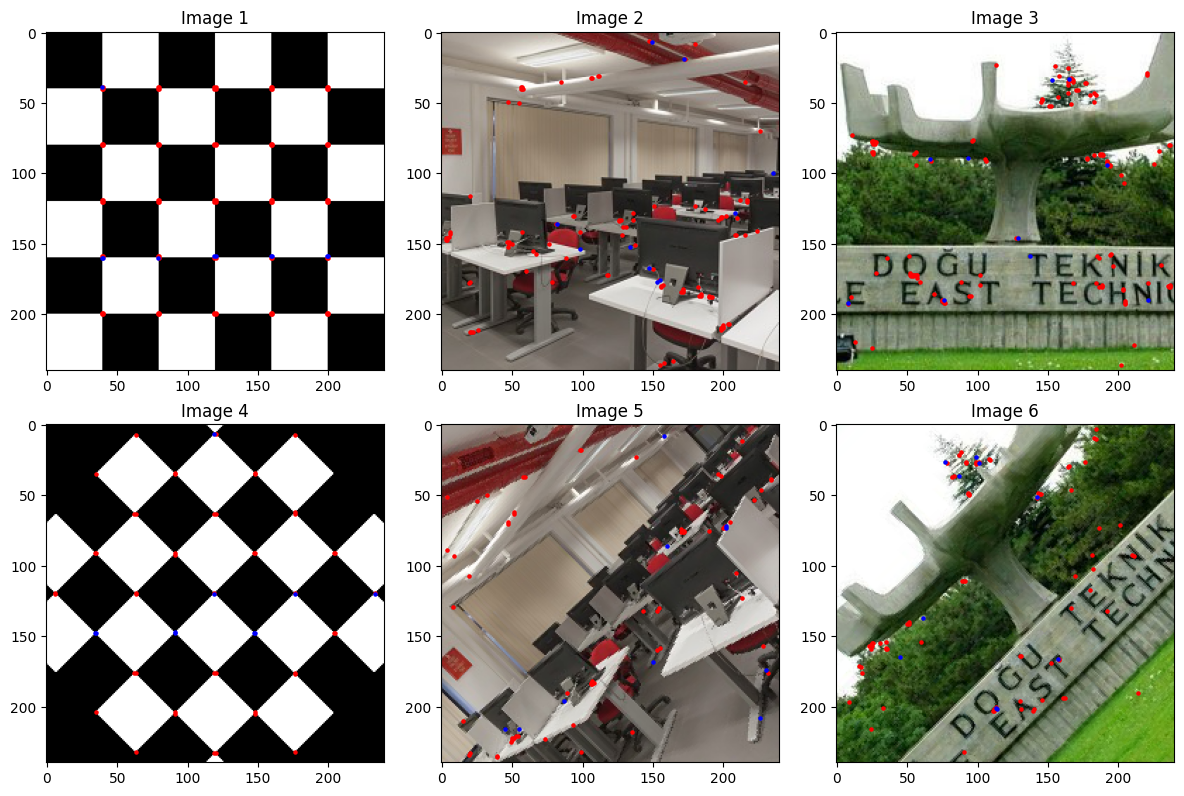

In [283]:
def harris_corner_detector_naive(img,window_size = 3,threshold = 1):

    ssd_matrix = np.zeros((img.shape[0],img.shape[1],8))

    directions = [(-1,0),(0,-1),(1,0),(0,1),(1,1),(1,-1),(-1,1),(-1,-1)]

    m=(window_size)//2

    if window_size % 2 == 1:
        margin = 0 
    else:
        margin = 1

    for x in range(m+1,img.shape[0]-(m+1)):
        for y in range(m+1,img.shape[1]-(m+1)):
            
            patch_first = img[x-m+margin:x+m+1,y-m+margin:y+m+1]
            ssd_for_directions = []
            for i in range(len(directions)):

                moved_patch = img[x-m+directions[i][0]+margin:x+m+directions[i][0]+1,y-m+directions[i][1]+margin:y+m+directions[i][1]+1]
                patch_difference = (moved_patch-patch_first)
                ssd_for_directions.append(np.sum(patch_difference**2))

            ssd_matrix[x,y] = np.array(ssd_for_directions)
    
    min_value_array = np.min(ssd_matrix,axis=2)
    corners = np.zeros_like(min_value_array)
    corners[min_value_array>threshold*min_value_array.max()]=1 
    top_indices = top_k_indices(min_value_array,corners,10,"min")
    for i in top_indices:
        corners[int(i[0]),int(i[1])]=2
    return corners

thresholds = [0.5,0.8,0.8,0.8,0.8,0.8]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(grayscales,thresholds):
    timebefore=time.time()
    corners_list.append(harris_corner_detector_naive(inp,threshold=thresh))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)

plotter(corners_list)


This is the first variant of Harris corner detector, which is relatively slower and less precise than the last (fast) variant of it. In this implementation, I firstly defined a window of size 'window_size x window_size', and then slided it over image. Then, for every step of this sliding, the window is shifted in every 8 possible directions and the SSD (Sum of Squared Differences) is calculated for the every direction. With these min values, the cornerness function of the image is created. Then, using this cornerness function,  a thresholding is done and if the minimum value at a point exceeds the threshold value, that point is considered to be a corner. In the examples above, you may easily observe that this implementation has some crucial drawbacks. First of all, the algorithm is sensitive to edges, namely it outputs a considerable amount of false positives, due to noises, since gaussian weighting did not applied. In addition, as one can see in the output of the cell, the processing time is much longer compared to the fast implementation. In addition, some "corner groups" are observed, due to the lack of Non-Maximum Suppression.  

## Naive Formula + Uniform Weighting

libpng warning: iCCP: known incorrect sRGB profile


Image1, processing time:  1.4658081531524658
Image2, processing time:  1.464203119277954
Image3, processing time:  1.4612340927124023
Image4, processing time:  1.4600069522857666
Image5, processing time:  1.4554460048675537
Image6, processing time:  1.4771640300750732


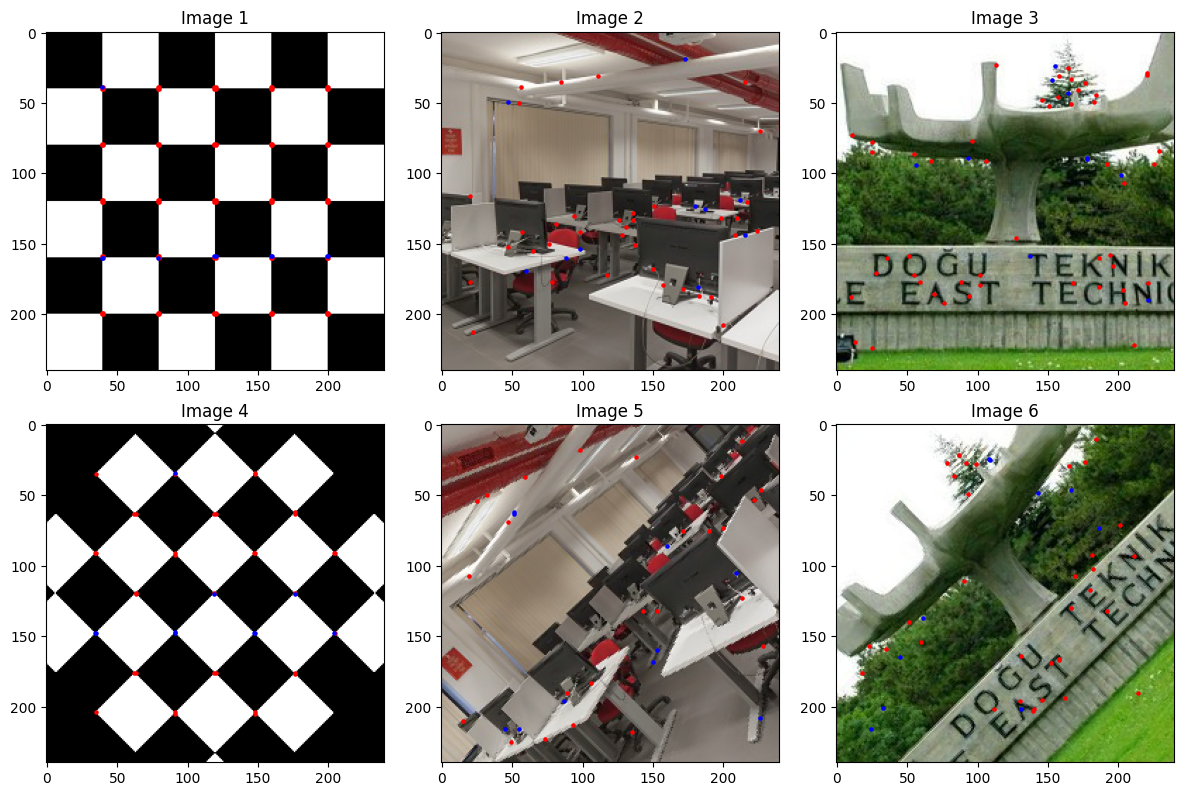

In [284]:
# Write your code here
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread("images/chessboard-rotated.png")
img2 = cv2.imread("images/chessboard.png")
img3 = cv2.imread("images/lab-rotated.png")
img4 = cv2.imread("images/lab.png")
img5 = cv2.imread("images/tree-rotated.png")
img6 = cv2.imread("images/tree.png")

#note

def harris_corner_detector_naive_with_nms(img,window_size = 3,threshold = 1,nms_radius = 9):

    ssd_matrix = np.zeros((img.shape[0],img.shape[1],8))

    directions = [(-1,0),(0,-1),(1,0),(0,1),(1,1),(1,-1),(-1,1),(-1,-1)]

    m=(window_size)//2

    if window_size % 2 == 1:
        margin = 0 
    else:
        margin = 1

    for x in range(m+1,img.shape[0]-(m+1)):
        for y in range(m+1,img.shape[1]-(m+1)):
            patch_first = img[x-m+margin:x+m+1,y-m+margin:y+m+1]
            ssd_for_directions = []
            for i in range(len(directions)):
                moved_patch = img[x-m+directions[i][0]+margin:x+m+directions[i][0]+1,y-m+directions[i][1]+margin:y+m+directions[i][1]+1]
                patch_difference = (moved_patch-patch_first)
                ssd_for_directions.append(np.sum(patch_difference**2))

            ssd_matrix[x,y] = np.array(ssd_for_directions)
    
    min_value_array = np.min(ssd_matrix,axis=2)
    corners = np.zeros_like(img)
    corners[min_value_array>threshold*min_value_array.max()]=1 
    
    non_maxima_indices = np.column_stack(np.where(corners == 1))

    processed_corners = NMS_eliminator(non_maxima_indices,min_value_array,nms_radius)

    top_indices = top_k_indices(min_value_array,processed_corners,10,"min")
    for i in top_indices:
        processed_corners[int(i[0]),int(i[1])]=2

    return processed_corners

thresholds = [0.8,0.8,0.8,0.8,0.8,0.8]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(grayscales,thresholds):
    timebefore=time.time()
    corners_list.append(harris_corner_detector_naive_with_nms(inp,threshold=thresh,nms_radius=9))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)
plotter(corners_list)

As one can see on the images above, the 'corner groups' are eliminated, different from the previous section. This is achieved using the algorithm "Non-Maximum Suppression". This algorithm takes all the detected points and defines a patch which is centered to that point. Then, the corner points in the patch are compared to each other according to their cornerness value and the ones except the one which has the maximum cornerness value are mapped to zero. Thus, a corner in the image is represented using only one corner point, instead of multiple points detected for a single corner. 

## Taylor's Approximation + Uniform Weighting

libpng warning: iCCP: known incorrect sRGB profile


Image1, processing time:  0.5889589786529541
Image2, processing time:  0.5942399501800537
Image3, processing time:  0.5900759696960449
Image4, processing time:  0.5866150856018066
Image5, processing time:  0.584583044052124
Image6, processing time:  0.5919840335845947


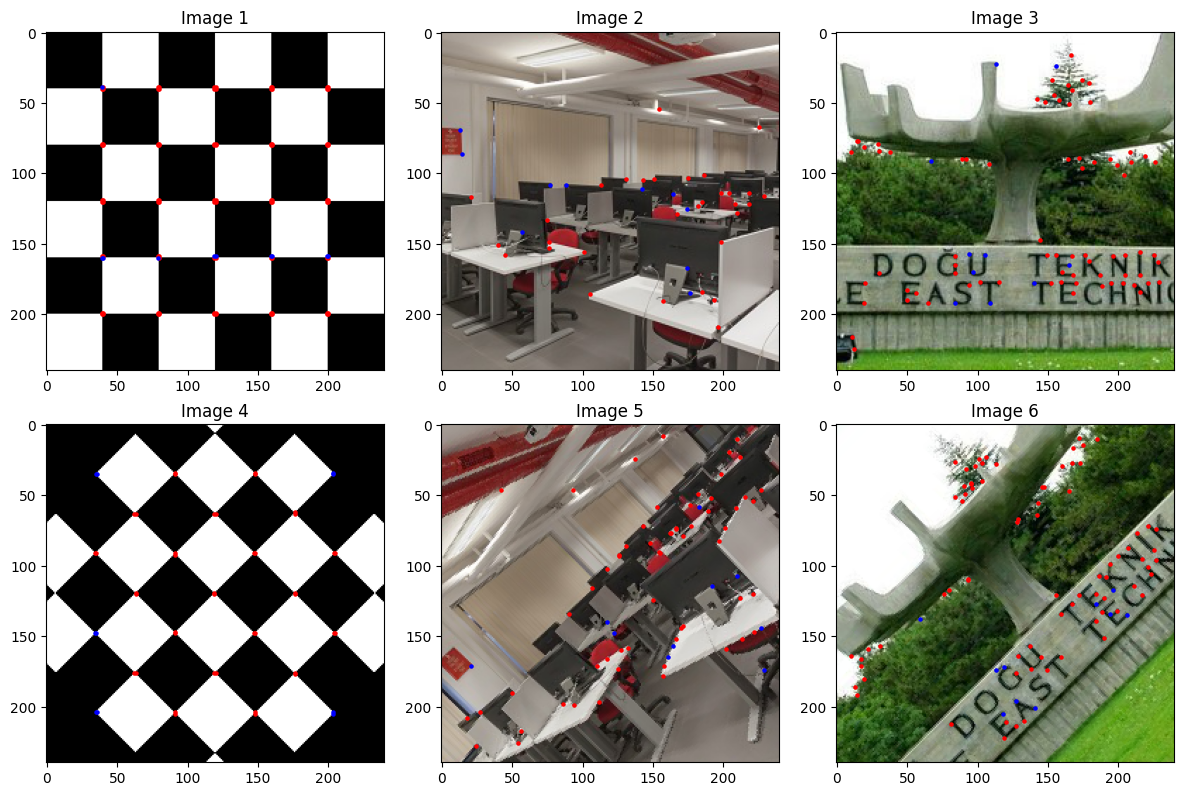

In [285]:
# Write your code here
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread("images/chessboard-rotated.png")
img2 = cv2.imread("images/chessboard.png")
img3 = cv2.imread("images/lab-rotated.png")
img4 = cv2.imread("images/lab.png")
img5 = cv2.imread("images/tree-rotated.png")
img6 = cv2.imread("images/tree.png")

#note


def harris_corner_detector_taylor_with_nms(img,window_size = 3,threshold = 0.1,nms_radius = 9):

    ssd_matrix = np.zeros((img.shape[0],img.shape[1],8))

    directions = [(-1,0),(0,-1),(1,0),(0,1),(1,1),(1,-1),(-1,1),(-1,-1)]
    directions = np.array(directions)

    if window_size % 2 == 1:
        m = (window_size-1)//2
        margin = 0 
    else:
        m=(window_size)//2-1
        margin = 1

    grad_array_x,grad_array_y = calculate_gradients(img)
    corners = np.zeros_like(img)

    for x in range(0,img.shape[0]):
        for y in range(0,img.shape[1]):

            Ixx = grad_array_x[x-m+margin:x+m+1,y-m+margin:y+m+1]**2
            Ixy = grad_array_x[x-m+margin:x+m+1,y-m+margin:y+m+1]*grad_array_y[x-m+margin:x+m+1,y-m+margin:y+m+1]
            Iyy = grad_array_y[x-m+margin:x+m+1,y-m+margin:y+m+1]**2

            Ixxsum = np.sum(Ixx)
            Ixysum = np.sum(Ixy)
            Iyysum = np.sum(Iyy)

            M_matrix = np.array([[Ixxsum,Ixysum],
                                 [Ixysum,Iyysum]])
            
            ssd_for_directions = np.dot(np.dot(directions, M_matrix.T), directions.T).diagonal()

            ssd_matrix[x,y] = ssd_for_directions
        

    min_value_array = np.min(ssd_matrix,axis=2)
    corners = np.zeros_like(img)
    corners[min_value_array>threshold*min_value_array.max()]=1 
    non_maxima_indices = np.column_stack(np.where(corners == 1))
    processed_corners = NMS_eliminator(non_maxima_indices,min_value_array,nms_radius)

    top_indices = top_k_indices(min_value_array,processed_corners,10,"min")
    for i in top_indices:
        processed_corners[int(i[0]),int(i[1])]=2

    return processed_corners


thresholds = [0.3,0.3,0.3,0.3,0.3,0.3]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(grayscales,thresholds):
    timebefore=time.time()
    corners_list.append(harris_corner_detector_taylor_with_nms(inp,threshold=thresh,nms_radius=9))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)
plotter(corners_list)

Applying Taylor series, the algorithm achieved a higher speed due to the lack of checking the auto-correlation of the sliding windows for every direction. In addition, the algorithm seems to be more powerful in terms of detecting corners. In other words, it has less false negatives. Thus, it is showed that the approximation of Taylor is useful here since it is both time efficient and convenient in terms of accuracy of the formula, on detecting corners.

## Fast Implementation + Uniform Weighting

Image1, processing time:  0.011956214904785156
Image2, processing time:  0.010631084442138672
Image3, processing time:  0.012780189514160156
Image4, processing time:  0.010931015014648438
Image5, processing time:  0.009286165237426758
Image6, processing time:  0.01196599006652832


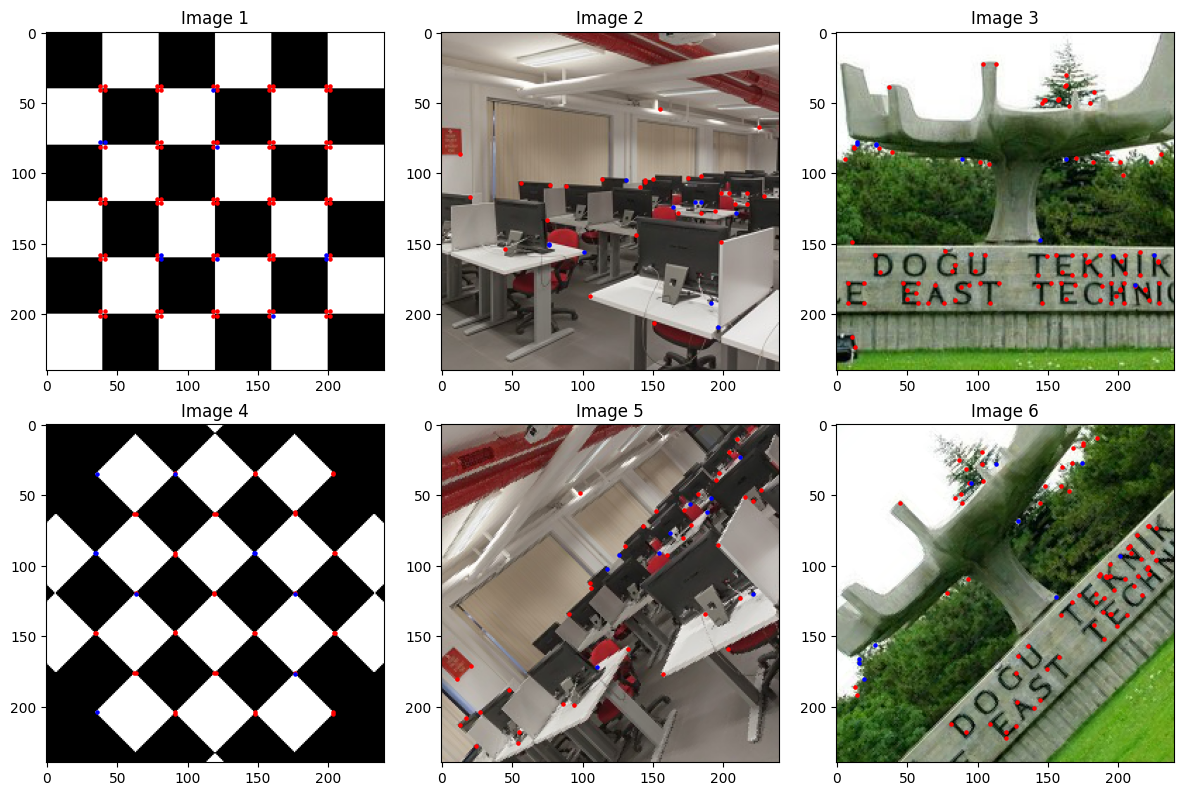

In [286]:
import cv2
import numpy as np


def harris_corner_detection(image,window_size=3,threshold=0.1,k=0.04,nms_radius=9):
    
    window = uniform_window(window_size)

    Ix,Iy = calculate_gradients(image)

    wIx = convolve2d(Ix, window, mode='same', boundary='symm')
    wIy = convolve2d(Iy, window, mode='same', boundary='symm')

    Ixxconvolved = convolve2d(wIx**2, window, mode='same', boundary='symm')
    Iyyconvolved = convolve2d(wIy**2, window, mode='same', boundary='symm')
    Ixyconvolved = convolve2d(wIx * wIy, window, mode='same', boundary='symm')

    harris_response = Ixxconvolved * Iyyconvolved - Ixyconvolved**2 - k * (Ixxconvolved + Iyyconvolved)**2
    # Thresholding to find corners

    processed_corners = nms_fast_implementation(harris_response,nms_radius,threshold)

    top_indices = top_k_indices(harris_response,processed_corners,10,"max")
    for i in top_indices:
        processed_corners[int(i[0]),int(i[1])]=2

    return processed_corners
thresholds = [0.1,0.1,0.1,0.1,0.1,0.1]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(grayscales,thresholds):
    timebefore=time.time()
    corners_list.append(harris_corner_detection(inp,threshold=thresh))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)
plotter(corners_list)


When we observe the processing time and outputs, we can easily see the significant improvement of the work done. Firstly, efficiency is much better compared to both the Naive implementation and Taylor approach, with the processing time being approximately 100x faster. As in the formulation, this efficiency is achieved by calculating the gradient matrix of the whole image plane and then convolving the window with the gradient output of the image. Then, algorithm is made even faster by the harris response definition, determinant and trace of this convolved output matrix is calculated instead of calculating the eigenvalues explicitly. In addition, corners in the image are detected in an accurate way, compared to the above sections. However, the accuracy is still not the best, because the window is uniform. In other words, since gaussian smoothing is not applied, the algorithm is still sensitive to the sharp edges etc. 

## Fast Implementation + Circular Weighting

Image1, processing time:  0.011250972747802734
Image2, processing time:  0.015938758850097656
Image3, processing time:  0.021844863891601562
Image4, processing time:  0.010641098022460938
Image5, processing time:  0.01574110984802246
Image6, processing time:  0.020264387130737305


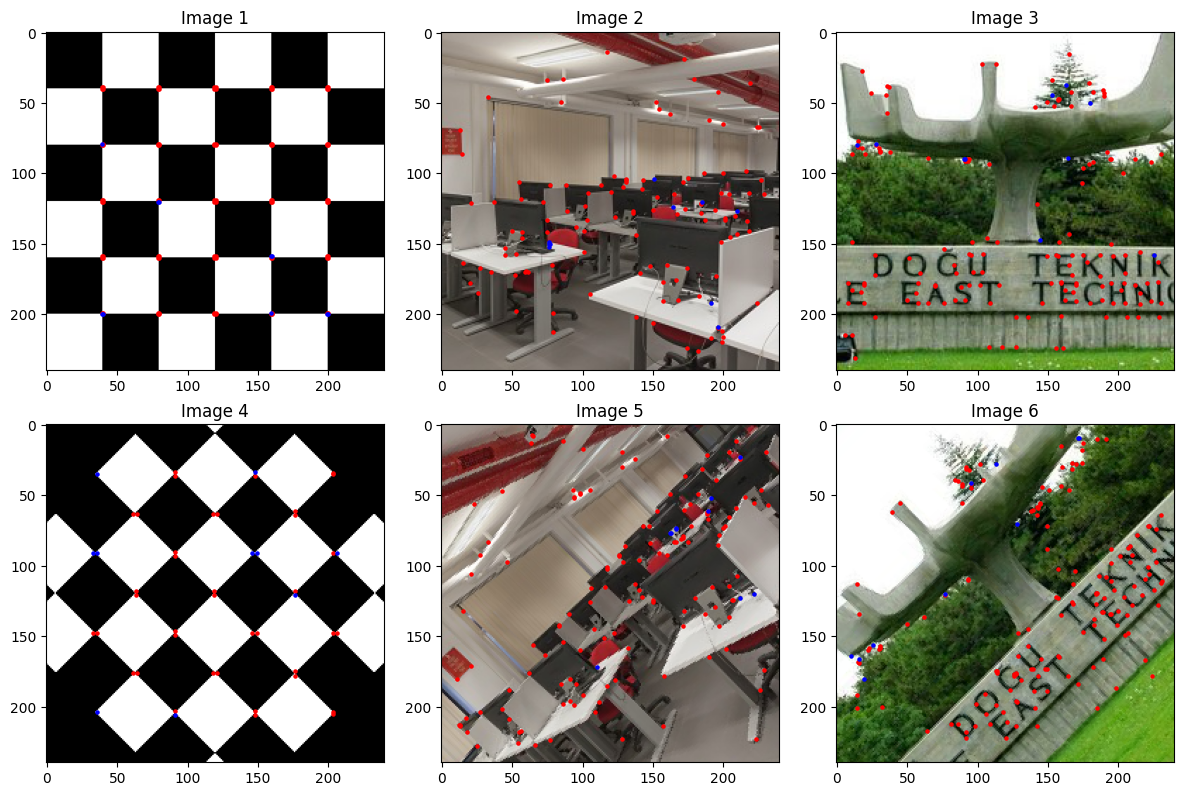

In [287]:
import cv2
import numpy as np


def harris_corner_detection_circular(image,window_size=3,threshold=0.1,k=0.04,nms_radius=9):

    window = circular_window(window_size)

    Ix,Iy = calculate_gradients(image)

    wIx = convolve2d(Ix, window, mode='same', boundary='symm')
    wIy = convolve2d(Iy, window, mode='same', boundary='symm')

    Ixxconvolved = convolve2d(wIx**2, window, mode='same', boundary='symm')
    Iyyconvolved = convolve2d(wIy**2, window, mode='same', boundary='symm')
    Ixyconvolved = convolve2d(wIx * wIy, window, mode='same', boundary='symm')
    
    harris_response = Ixxconvolved * Iyyconvolved - Ixyconvolved**2 - k * (Ixxconvolved + Iyyconvolved)**2
    # Thresholding to find corners

    processed_corners = nms_fast_implementation(harris_response,nms_radius,threshold)

    top_indices = top_k_indices(harris_response,processed_corners,10,"max")
    for i in top_indices:
        processed_corners[int(i[0]),int(i[1])]=2

    return processed_corners
thresholds = [0.01,0.01,0.01,0.01,0.01,0.01]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(grayscales,thresholds):
    timebefore=time.time()
    corners_list.append(harris_corner_detection_circular(inp,threshold=thresh))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)
plotter(corners_list)



As can be seen by examining the processing times, the approach is still super fast compared to the other approaches, as expected. In terms of the accuracy of detection, circular weighting seems to contribute to the elimination of false positives, because it help in cases where corners are detected in textured regions or near edges. Thus, the overall algorithm makes a better work detecting corners. 

## Fast Implementation + Gaussian Weighting

Image1, processing time:  0.014600038528442383
Image2, processing time:  0.016464710235595703
Image3, processing time:  0.023669719696044922
Image4, processing time:  0.010711193084716797
Image5, processing time:  0.016654014587402344
Image6, processing time:  0.02332305908203125


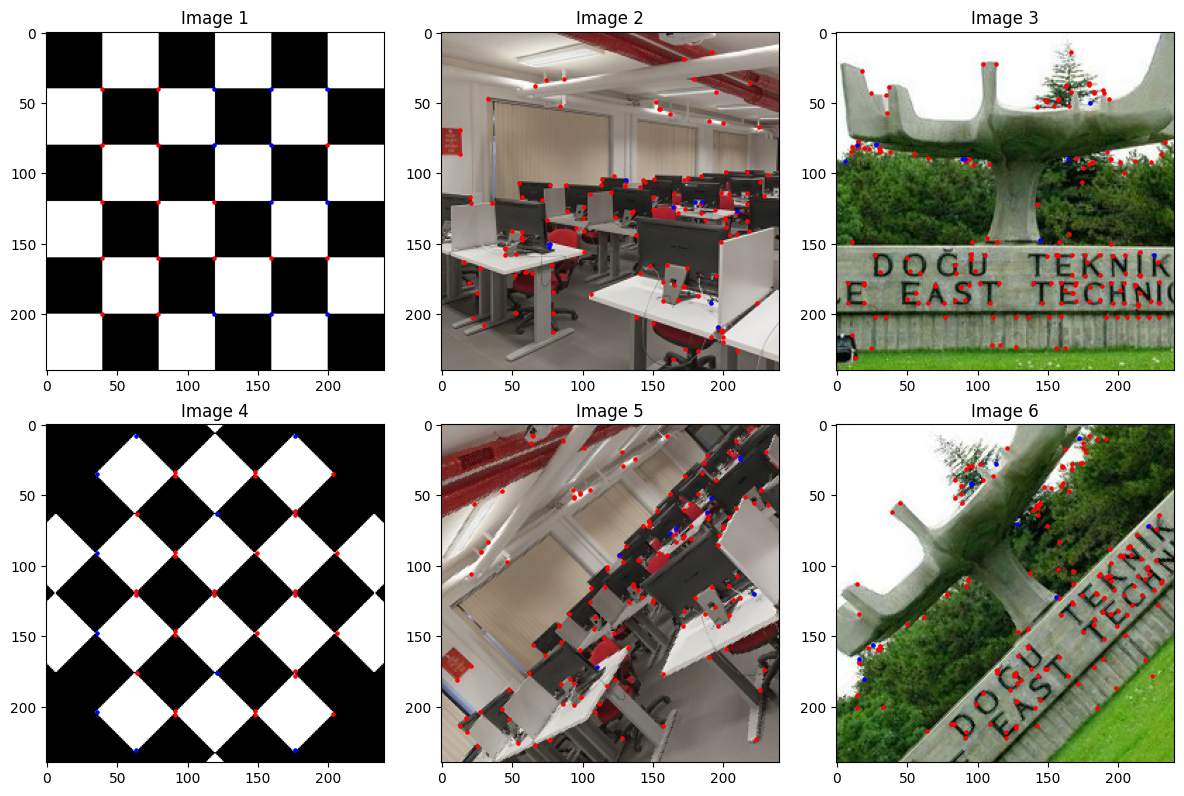

In [288]:
import cv2
import numpy as np


def harris_corner_detection_gaussian(image,window_size=3,sigma=1,threshold=0.1,k=0.04,nms_radius=9):

    window = gaussian_window(window_size,sigma)

    Ix,Iy = calculate_gradients(image)

    wIx = convolve2d(Ix, window, mode='same', boundary='symm')
    wIy = convolve2d(Iy, window, mode='same', boundary='symm')

    Ixxconvolved = convolve2d(wIx**2, window, mode='same', boundary='symm')
    Iyyconvolved = convolve2d(wIy**2, window, mode='same', boundary='symm')
    Ixyconvolved = convolve2d(wIx * wIy, window, mode='same', boundary='symm')

    harris_response = Ixxconvolved * Iyyconvolved - Ixyconvolved**2 - k * (Ixxconvolved + Iyyconvolved)**2
    # Thresholding to find corners

    processed_corners = nms_fast_implementation(harris_response,nms_radius,threshold)

    top_indices = top_k_indices(harris_response,processed_corners,10,"max")
    for i in top_indices:
        processed_corners[int(i[0]),int(i[1])]=2

    return processed_corners
thresholds = [0.01,0.01,0.01,0.01,0.01,0.01]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(grayscales,thresholds):
    timebefore=time.time()
    corners_list.append(harris_corner_detection_gaussian(inp,threshold=thresh))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)
plotter(corners_list)



With the smoothing effect achieved by the gaussian window, the accuracy of the algorithm is improved compared to the uniform and circular window usage. Thus, the algorithm has become less sensitive to the sharp edges and rotation angle differences. 

## Fast Implementation + Gaussian Weighting + RGB Split

Image1, processing time:  0.047019004821777344
Image2, processing time:  0.06371021270751953
Image3, processing time:  0.10795903205871582
Image4, processing time:  0.043540000915527344
Image5, processing time:  0.06962895393371582
Image6, processing time:  0.11118698120117188


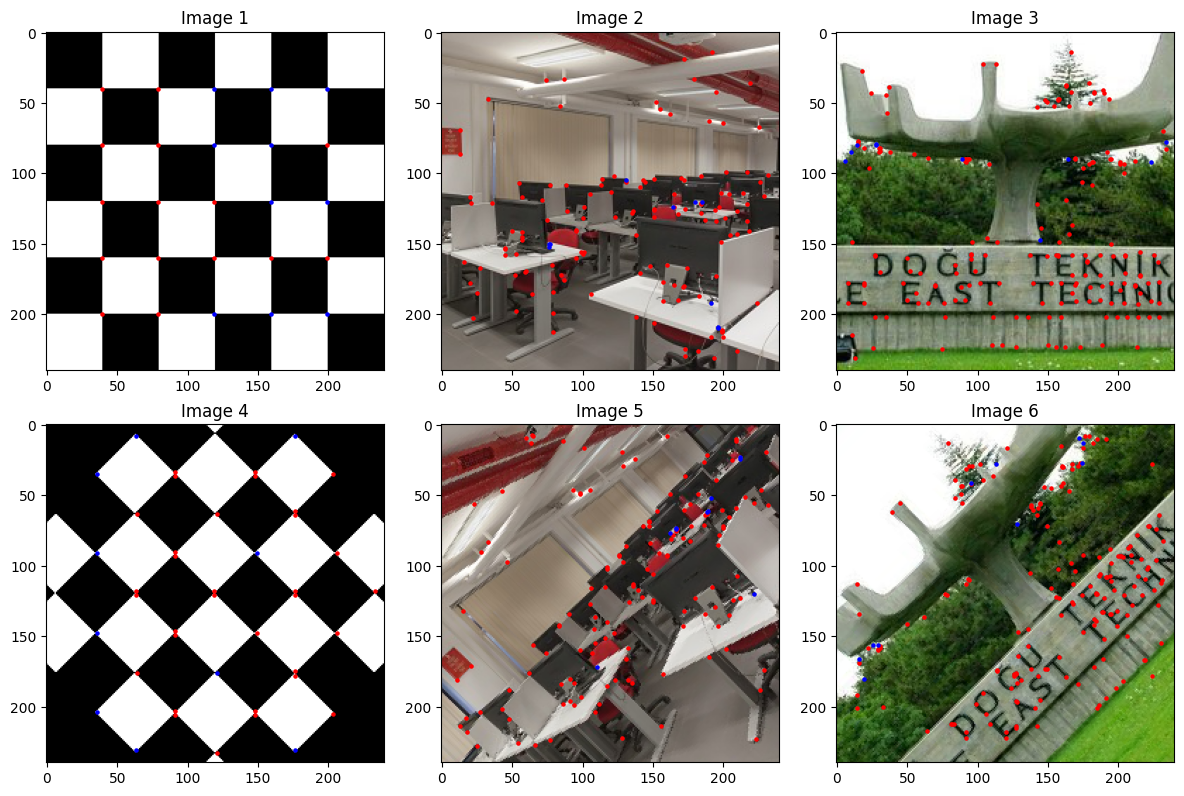

In [289]:
def RGB_split_fast_gaussian(image,window_size=3,sigma=1,threshold=0.1,k=0.04,nms_radius=9):

    harris_responses = np.zeros((image.shape[0],image.shape[1],3))

    for channel in range(0,3):

        window = gaussian_window(window_size,sigma)
        
        img_channel = image[:,:,channel]
        Ix,Iy = calculate_gradients(img_channel)

        wIx = convolve2d(Ix, window, mode='same', boundary='symm')
        wIy = convolve2d(Iy, window, mode='same', boundary='symm')

        Ixxconvolved = convolve2d(wIx**2, window, mode='same', boundary='symm')
        Iyyconvolved = convolve2d(wIy**2, window, mode='same', boundary='symm')
        Ixyconvolved = convolve2d(wIx * wIy, window, mode='same', boundary='symm')

        harris_response = Ixxconvolved * Iyyconvolved - Ixyconvolved**2 - k * (Ixxconvolved + Iyyconvolved)**2
        # Thresholding to find corners

        harris_responses[:,:,channel] = harris_response

    
    processed_corners = nms_rgb_implementation(harris_responses,nms_radius,threshold)

    top_indices = top_k_indices(harris_response,processed_corners,10,"max")
    for i in top_indices:
        processed_corners[int(i[0]),int(i[1])]=2

    return processed_corners

    
thresholds = [0.01,0.01,0.01,0.01,0.01,0.01]
window_sizes = [3,3,3,3,3,3]
corners_list = []
for inp,thresh in zip(images,thresholds):
    timebefore=time.time()
    corners_list.append(RGB_split_fast_gaussian(inp,threshold=thresh))
    timelater=time.time()
    print(f"Image{len(corners_list)}, processing time: ",timelater-timebefore)
plotter(corners_list)


In this part, different from the other implementations, harris response is calculated through each channel, and then a harris_responses volume is created. Then, instead of finding the maximum over a 2D neighborhood, the maximum is searched over a neighborhood volume (box). Then, the x and y coordinates of this maximum over the neighborhood is considered as a corner coordinate. As a result, we can conclude that the algorithm is even more accurate since all channels are examined independently and then they are accumulated over the neighborhood. In addition, there is no difference in the images (Image1,Image4), because they are already grayscale. In terms of efficiency, the algorithm works a bit slower then the grayscale implementation as expected but there is not a huge difference between the processing times, as can be seen.

# Conclusion

Working on this Take Home Exam, the development process of the Harris Corner Detector is examined. Firstly, the naive formula is implemented to understand the basis logic behing the algorithm, which is forming windows over the image and checking their auto-correlation values in 8 directions to understand if there is a change in all directions. If there are large changes in each directions, which determined by considering the direction which has the smallest change, then the center of this window is decided to be a corner. Then, the Taylor Series Approximation is examined, and it is showed that using only the first place derivatives of the Taylor Series Expansion is enough in terms of accuracy of corner detection, and using this formula leads to an important efficiency improvement, since the changes in every directions didn't considered one by one. Then, the original Harris Corner Detection is implemented, which is much faster and accurate compared to the other implementations. In this implementation, the important ideas which makes it faster:
- the window is convolved over the gradient matrices, which are pre-calculated,
- window sliding is not used,
- eigenvalue computation is avoided, using the determinant and trace of the H matrix

After that part, the contribution of the use of circular and gaussian windows are examined. It is observed that the sensitivity of the algorithm to sharp edges and intensity changes can be reduced using the gaussian and circular weighting. Especially, the false-positive reduction achieved by smoothing effect of gaussian window is proved in an exact way. 

As a result, we gained a deep insight on how corner detection algorithm is improved through the crucial steps and we inferred the above mentioned results.